***
### Table of Contents
1. [Importing Data](#1)
2. [Creating custom causalNet data object](#2) for embedding models
3. [Training](#3) embedding models
    * 3.1 Training a [new model](#3.1)
    * 3.2 Training a model from [checkpoint](#3.2)
    * 3.3 [Save/load](#3.3) a model 
4. [Getting predictions](#4) on a holdout
5. [Visualize your](#5) embeddings
***

In [1]:
%load_ext autoreload
%autoreload 2
from causalnet import metrics, data_processing, model, train
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
os.chdir("..")
np.random.seed(42)

<a id="1"></a>
### 1. Importing data

This package was created to streamline process for performing categorical embedding & subsequently using it for causal inference modelling. This notebook tutorial is for building embedding models using this package.
The data we use here is a tweedie distributed [claims amount data](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html) from sklearn. You can follow the link to learn more about the data

In [2]:

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml

#Function to fetch the data
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)["data"]
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)["data"]

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]



df = load_mtpl2(n_samples=300000)
df

#Categorical Variable definition
categorical_variables = df.select_dtypes(include=['object','category']).columns.tolist()

#Continuous variable definition
continuous_variables = df.select_dtypes(include=['number']).columns.tolist()
##Removing our target variable
continuous_variables.remove('ClaimAmount')

#Treatment variable definition
treatment=["treatment"]
df["treatment"] = np.random.choice([0, 1], size=(len(df),), p=[2/3, 1/3])

#Weight variable definition
weight=["weight"]
df["weight"] = np.random.uniform(low=0.9, high=1.1, size=len(df))

#Target variable definition
target = ['ClaimAmount']


The `preprocessing()` function that creates our custom causalNet data object takes in a maximum value for your target variable if you choose to clip your target

In [3]:
percent_clip = 0.7

npTarget = df.ClaimAmount.values
filtered = npTarget[npTarget>0.1]

target_clip_val = np.quantile(filtered,percent_clip)

total, gt_percentile = len(npTarget), len(npTarget[npTarget>target_clip_val])
print("If we clip `target` values above the {}th percentile, we'd alter {:.2}% of our data.\nThis is a clip value of {:.4}".format(int(percent_clip*100),100*gt_percentile/total, target_clip_val))


If we clip `target` values above the 70th percentile, we'd alter 1.3% of our data.
This is a clip value of 1.172e+03


<a id="2"></a>
### 2. Creating a custom causalNet data object:

The data_processing function returns a custom data object that makes using this package easier. It has some data processing functionalities which you can use as desired:
* Weighting your target variable
* Target variable can be scaled between 0 and 1
* Setting max value of your response

The preprocessing does the below steps:
1. It creates tensors for the categorical variables. Tensorflow expects the data that feeds the categorical embeddings to be in a very specific format, namely sequential integers with no gaps starting at 0.
2. It bundles the continuous variables in a numpy frame of the type expected by tensorflow.
3. Lastly, creates training and validation indexes. The train/test split uses the sklearn train_test_split function, and so alternative seeds and split values may be passed using the random_state and train_split arguments, respectively.


Now lets let's create our `causalNet` data object which is essentially a dictionary that serparates out our categorical & continuous variables, along with target & weight columns.

In [4]:
causal_net_data = data_processing.preprocessing(data = df, 
                      categorical_variables = categorical_variables, 
                      continuous_variables = continuous_variables, 
                      target_variable = target, 
                      weight_variable = weight,  
                      treatment_variable = treatment, 
                      scale_y = True,
                      weight_target = False, # Setting to default as we dont want to weight our target variable
                      train_split = .8, #Default
                      random_state = 11,
                      user_cat_level_definition = None,
                      y_clip=target_clip_val
                        )

Setting max value of target variable at 1172.00

Normalizing your y, please hold.



<a id="3"></a>
### 3. Embedding Model training

<a id="3.1"></a>
#### 3.1 Training embedding model from scratch

The package checkpoints your model after every round in your training process in the embed_checkpoint folder(created relative to your code). Helpful if your training stops & you want to resume it from last checkpoint.

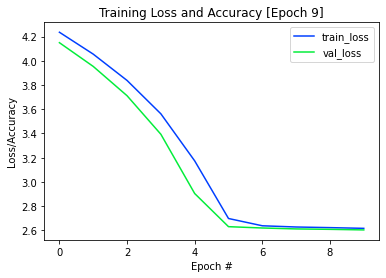

INFO:tensorflow:Assets written to: embed_checkpoint\model.10-2.62\assets


INFO:tensorflow:Assets written to: embed_checkpoint\model.10-2.62\assets


In [5]:
tf.random.set_seed(101)
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-7, 
                 beta_1=.9, 
                 beta_2=.999, 
                 epsilon=1e-3,
                 amsgrad=True)

model = train.embeddings_train(causal_net_data,
                                            optimizer=optimizer,
                                            loss='tweedie_loss', #default
                                            epochs = 10)


<a id="3.2"></a>
#### 3.2 Training from a stored checkpoint:

This package automatically looks for model checkpoints in the embed_checkpoint folder & if the input variables used in the checkpointed model matches, it will automatically start the training from that checkpoint.

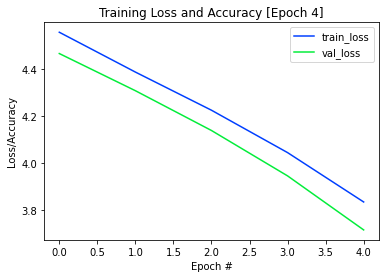

INFO:tensorflow:Assets written to: embed_checkpoint\model.05-3.83\assets


INFO:tensorflow:Assets written to: embed_checkpoint\model.05-3.83\assets


In [6]:
model = train.embeddings_train(causal_net_data,
                                            optimizer=optimizer,
                                            loss='tweedie_loss', #default
                                            epochs = 5)

<a id="3.3"></a>
#### 3.3 Save/Load your models:

In [7]:
model.save('embed_final')

INFO:tensorflow:Assets written to: embed_final\assets


INFO:tensorflow:Assets written to: embed_final\assets


In [8]:
from tensorflow.keras.models import load_model
new_embed = load_model('embed_final')

In [9]:
## Clear the checkpoint folders, if you want to start from scratch
# import shutil
# shutil.rmtree('embed_checkpoint')
# shutil.rmtree('embed_final')

<a id="4"></a>
### 4. Getting predictions from the models on your data:

Since our custom data object is stored as a tensor dictionary , we fetch the data in a loop.

In [10]:
x_data = causal_net_data.x_preprocess
test_index = causal_net_data.test_index

x_test = {}
for item in x_data:
    x_test[item] = x_data[item][test_index]

In [11]:
embed_preds = new_embed.predict(x_test)
print(embed_preds)

[[0.6669784 ]
 [0.6494263 ]
 [0.64463437]
 ...
 [0.7243917 ]
 [0.7172478 ]
 [0.7346479 ]]


<a id="4.1"></a>
#### 4.1 : Convert results into a pandas dataFrame:

In [12]:
resultsDf = df.iloc[test_index].copy()
resultsDf['preds'] = embed_preds
for col in continuous_variables+categorical_variables:
    resultsDf[col] = resultsDf[col]
resultsDf

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,treatment,weight,preds
IDpol,,,,,,,,,,,,,,,
126657.0,0.0,0.50,C,7.0,6.0,53.0,50.0,B1,Regular,276.0,R82,0.0,1,0.993812,0.666978
171916.0,0.0,0.16,C,7.0,4.0,22.0,85.0,B1,Regular,165.0,R53,0.0,0,0.986525,0.649426
1022114.0,0.0,1.00,B,7.0,12.0,50.0,50.0,B2,Diesel,91.0,R24,0.0,0,1.083502,0.644634
100829.0,0.0,0.75,D,8.0,5.0,53.0,50.0,B6,Diesel,644.0,R53,0.0,1,0.999302,0.725127
2108927.0,1.0,1.00,C,7.0,14.0,57.0,50.0,B1,Regular,283.0,R25,1172.0,1,0.995826,0.651336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175618.0,0.0,1.00,A,5.0,17.0,77.0,50.0,B1,Regular,29.0,R24,0.0,1,1.038246,0.609120
2141911.0,0.0,0.06,E,6.0,0.0,58.0,50.0,B2,Diesel,6308.0,R11,0.0,1,1.080838,0.727222
1186372.0,0.0,0.50,D,8.0,9.0,71.0,66.0,B6,Diesel,1326.0,R93,0.0,0,1.068394,0.724392


<a id="5"></a>
### 5. Visualise your Embeddings

`causalNet` package also allows you to plot & visualise your embeddings on  3d or 2d plane.

In [13]:
from causalnet import viz

In [14]:
embed_dict = viz.fetch_model_var_info(new_embed, causal_net_data)

In [15]:
embed_dict['VehBrand']

array([[-0.02172531, -0.04564541,  0.03563943,  0.03400467,  0.00046341,
         0.03274227],
       [ 0.02079226, -0.04075596, -0.00527516, -0.0163084 ,  0.04216262,
        -0.04708099],
       [-0.03758591,  0.04703913, -0.03655201, -0.03742458, -0.00557537,
        -0.01155691],
       [ 0.01261163,  0.03124092, -0.02728995, -0.00743573, -0.00790766,
         0.01812935],
       [-0.02596876, -0.01541566,  0.00500228, -0.04620003, -0.04877267,
        -0.02768112],
       [-0.01225621, -0.02357766,  0.02899919, -0.00839555,  0.04024746,
        -0.00611283],
       [-0.04612624, -0.00778681,  0.04163323, -0.00783852,  0.03653684,
        -0.02528948],
       [ 0.03131895, -0.02573475,  0.0488893 , -0.04776468,  0.03255014,
        -0.02822786],
       [-0.02971343, -0.05069681, -0.00996928,  0.01449296, -0.02772924,
         0.0139051 ],
       [-0.01100326,  0.02203375, -0.03263778, -0.00722222,  0.01198067,
        -0.04964106],
       [ 0.01434193, -0.01090939,  0.02869077,  0.

Visualizer can plot "simple" categoricals that have up to three embeddings...

In [16]:
viz.embeddings_to_pandas('VehGas', embed_dict, causal_net_data.categorical_level_dict)

,VehGas,embedding_0,embedding_1
0,Regular,0.000095,-0.017825
1,Diesel,-0.011924,-0.020680


<Figure size 432x288 with 0 Axes>

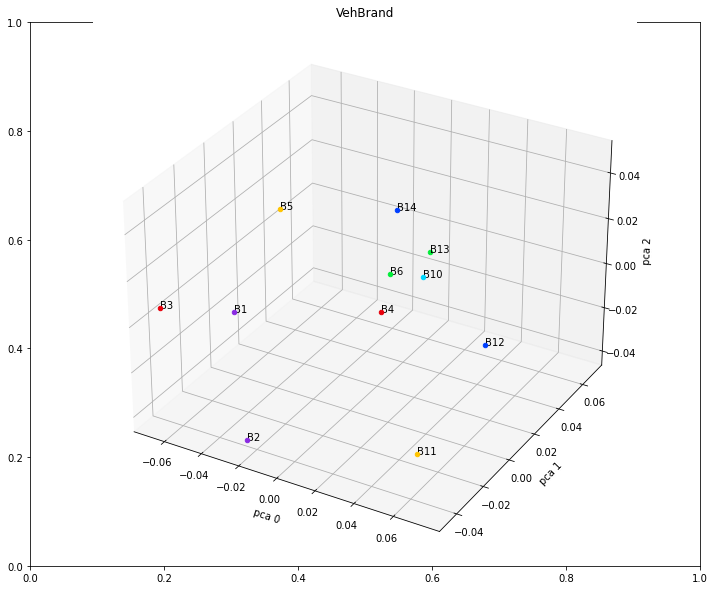

In [17]:
viz.embeddings_viz('VehBrand', new_embed, causal_net_data, figsize=(12,10))

<Figure size 432x288 with 0 Axes>

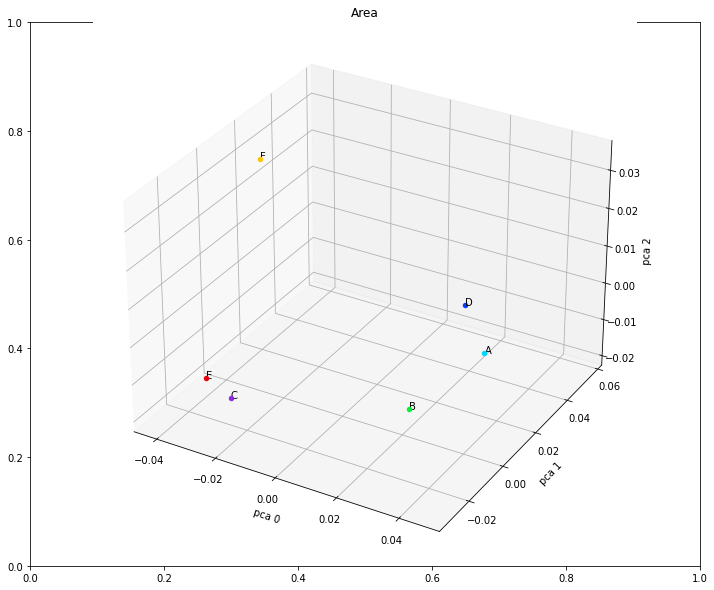

In [18]:
viz.embeddings_viz('Area', new_embed, causal_net_data, figsize=(12,10))

<Figure size 432x288 with 0 Axes>

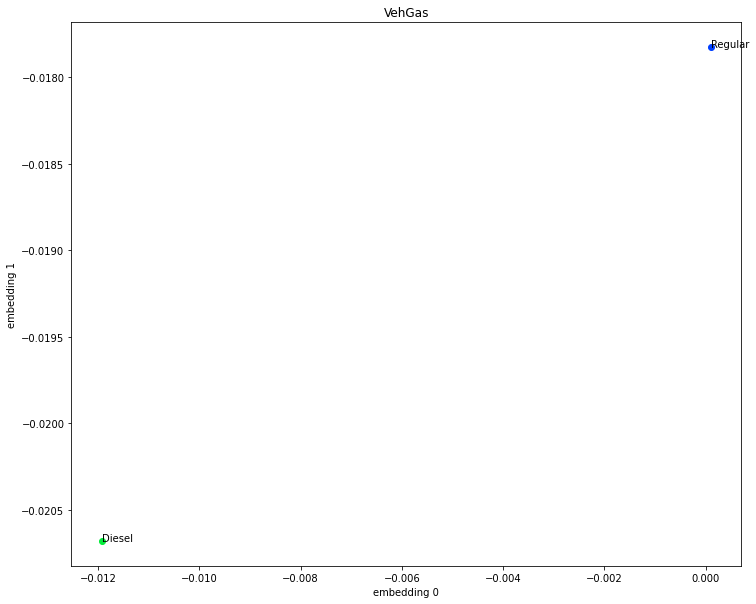

In [19]:
viz.embeddings_viz('VehGas', new_embed, causal_net_data, figsize=(12,10))

The `causalNet` package uses the sklearn PCA tool to plot variables with more than 3 embeddings. By default it plots it on a 3-dimensional view but you can plot it in 2d too 

<Figure size 432x288 with 0 Axes>

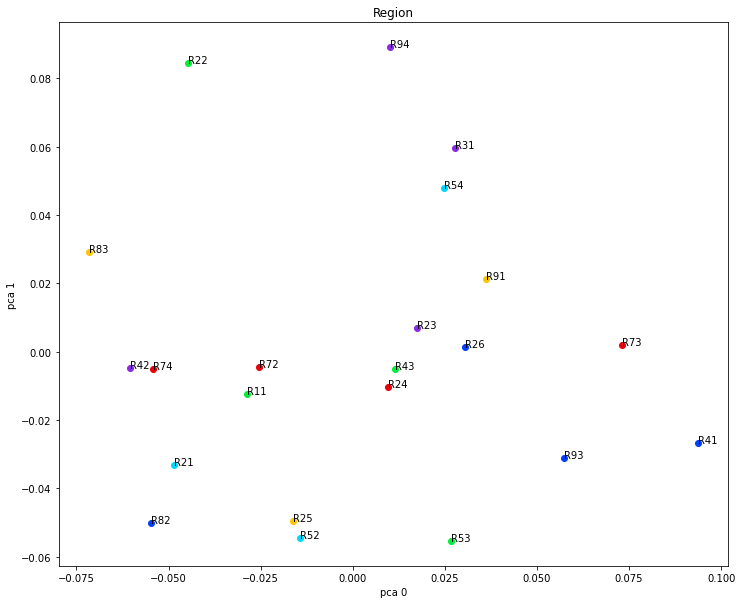

In [20]:
viz.embeddings_viz('Region', new_embed, causal_net_data, figsize=(12,10), pca_size=2)

<Figure size 432x288 with 0 Axes>

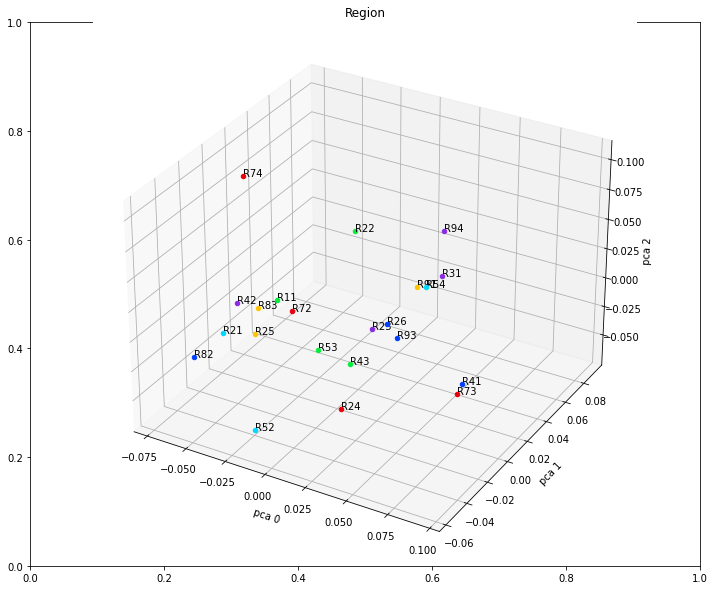

In [21]:
viz.embeddings_viz('Region', new_embed, causal_net_data, figsize=(12,10))